In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [2]:
fao_data = pd.read_csv("datasets/latest0205.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Rodenticides – Other-3,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Bipiridils-3,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Herbicides – Sulfonyl ureas-3,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2,Rodenticides – Anti-coagulants-3
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,0.0,0.0,0.0,Sunflower seed,-0.8656,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,-81.0,0.0,0.0,31.0,0.41,0.41,0.41
2020-01-01,-106607.0,-55584.0,26854.0,Hop cones,0.2323,-15.0,-241.0,142.0,140.0,-773.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.41,0.41
2020-01-01,0.0,0.0,0.0,Rape or colza seed,1.4064,0.0,0.0,0.0,0.0,0.0,...,0.0,-84.0,0.0,0.0,4.0,0.0,0.0,0.10,0.41,0.41
2020-01-01,0.0,0.0,0.0,Soya beans,-1.0056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-84.0,0.0,0.0,4.0,0.0,0.10,0.10,0.41


In [3]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals',
       'Industrial_crops'], dtype=object)

In [4]:
shap_df = pd.DataFrame()

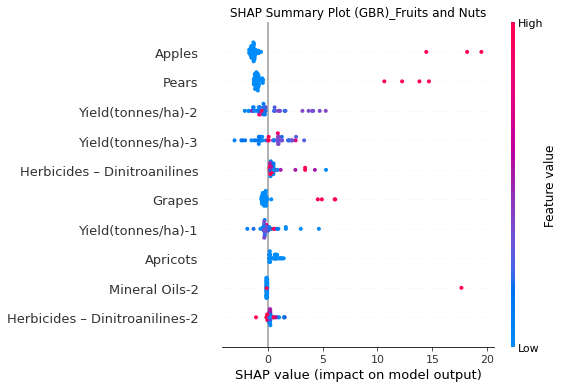

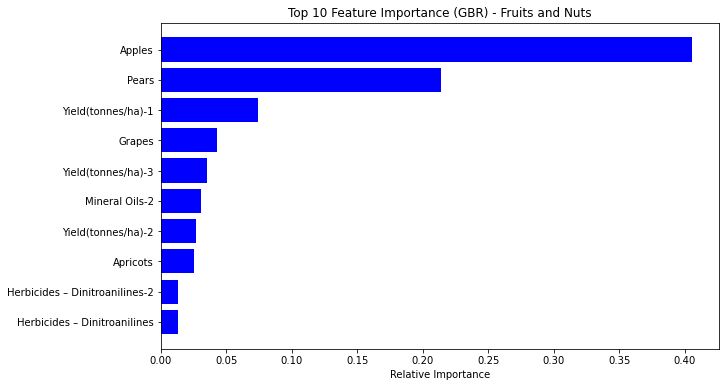

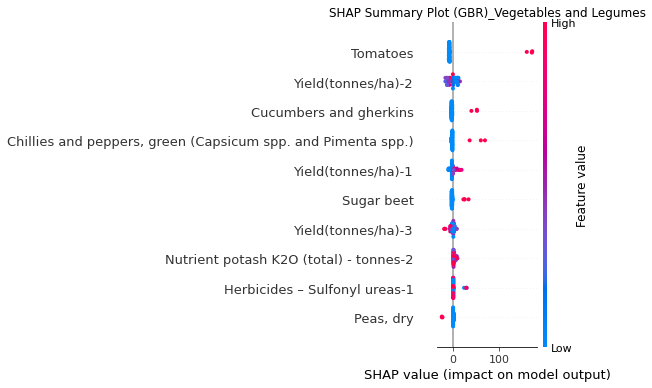

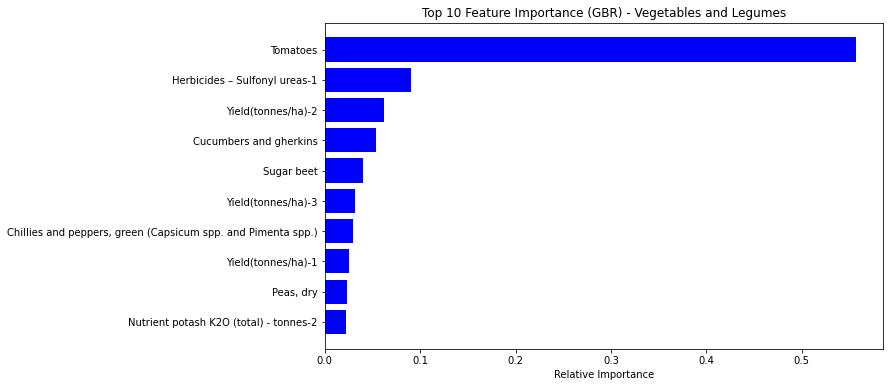

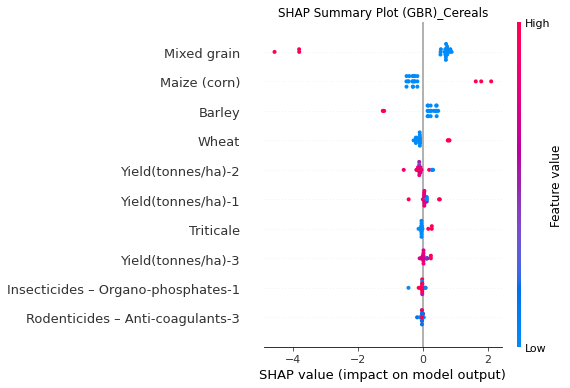

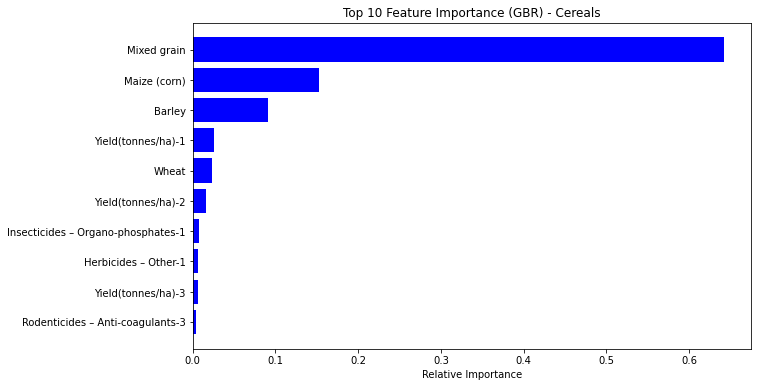

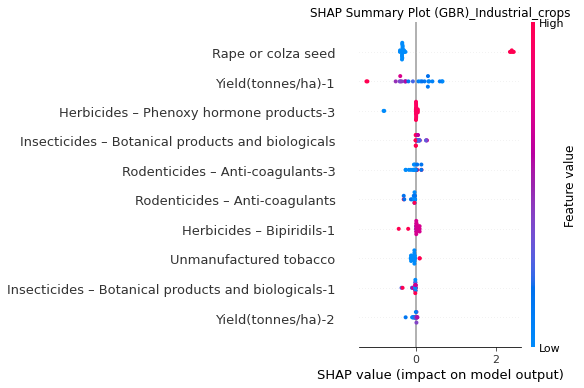

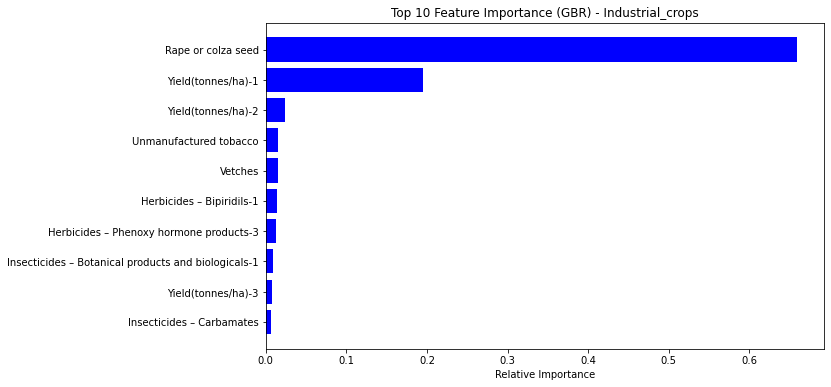

In [9]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Item"]], prefix='', prefix_sep='')

    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    

    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)

    x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)
    regressor = GradientBoostingRegressor(max_depth=100, n_estimators=1000, learning_rate= 1)
    regressor.fit(x_train, y_train)


    #prediction of new value
    y_pred = regressor.predict(x_test)

    #shap implementation
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(x_test)
    explainer = shap.TreeExplainer(regressor)
    
    shap_values = explainer.shap_values(x_test)
    
    plt.title("SHAP Summary Plot (GBR)" + "_" + cat)
    shap.summary_plot(shap_values, x_test, max_display= 10)
    plt.show()
    shap_df_crop = pd.DataFrame(shap_values, columns=x_test.columns)
    shap_mean_crop = shap_df_crop.mean()
    shap_df[cat] = shap_mean_crop 
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[-10:]  # select the indices of top 10 features
    features = x_train.columns
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importance (GBR) - ' + cat)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show() 
    
 


In [6]:
shap_df = shap_df.add_prefix('mean shap values (GBM)_')
shap_df

,mean shap values (GBM)_Fruits and Nuts,mean shap values (GBM)_Vegetables and Legumes,mean shap values (GBM)_Cereals,mean shap values (GBM)_Industrial_crops
Nutrient nitrogen N (total) - tonnes,3.570574e-18,0.000000e+00,-0.000013,0.000000
Nutrient phosphate P2O5 (total) - tonnes,0.000000e+00,5.847867e-05,0.000000,0.000000
Nutrient potash K2O (total) - tonnes,0.000000e+00,5.205205e-02,-0.000032,-0.000024
Fung & Bact – Benzimidazoles,0.000000e+00,8.342966e-18,0.000000,0.000000
"Fung & Bact – Diazines, morpholines",0.000000e+00,-2.630301e-05,0.000085,-0.000362
...,...,...,...,...
Plums and sloes,1.732241e-03,NaN,NaN,NaN
Raspberries,-3.023346e-04,NaN,NaN,NaN
Sour cherries,0.000000e+00,NaN,NaN,NaN
Strawberries,-5.793991e-02,NaN,NaN,NaN


In [7]:
shap_df['mean_shap_value'] = shap_df.mean(axis=1)
shap_df

,mean shap values (GBM)_Fruits and Nuts,mean shap values (GBM)_Vegetables and Legumes,mean shap values (GBM)_Cereals,mean shap values (GBM)_Industrial_crops,mean_shap_value
Nutrient nitrogen N (total) - tonnes,3.570574e-18,0.000000e+00,-0.000013,0.000000,-3.330580e-06
Nutrient phosphate P2O5 (total) - tonnes,0.000000e+00,5.847867e-05,0.000000,0.000000,1.461967e-05
Nutrient potash K2O (total) - tonnes,0.000000e+00,5.205205e-02,-0.000032,-0.000024,1.299899e-02
Fung & Bact – Benzimidazoles,0.000000e+00,8.342966e-18,0.000000,0.000000,2.085742e-18
"Fung & Bact – Diazines, morpholines",0.000000e+00,-2.630301e-05,0.000085,-0.000362,-7.579744e-05
...,...,...,...,...,...
Plums and sloes,1.732241e-03,NaN,NaN,NaN,1.732241e-03
Raspberries,-3.023346e-04,NaN,NaN,NaN,-3.023346e-04
Sour cherries,0.000000e+00,NaN,NaN,NaN,0.000000e+00
Strawberries,-5.793991e-02,NaN,NaN,NaN,-5.793991e-02


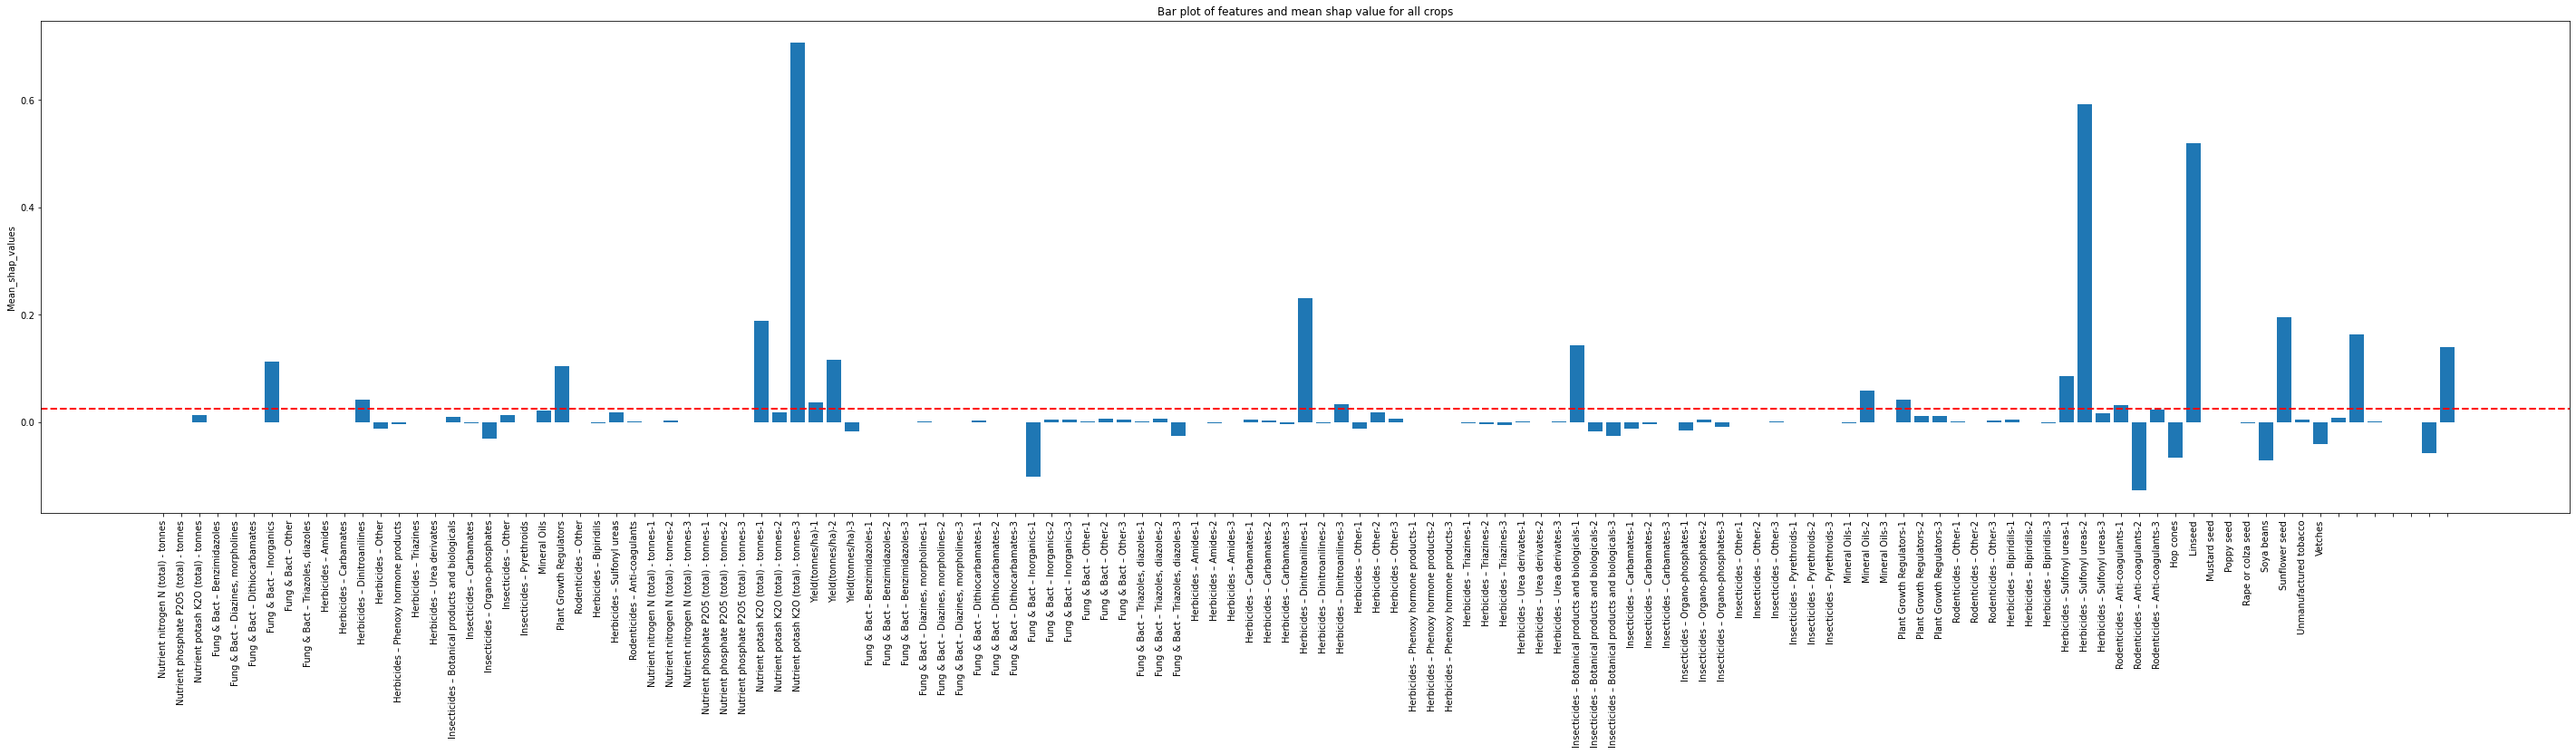

In [8]:
mean_shap = shap_df['mean_shap_value'].mean()
fig, ax = plt.subplots(figsize=(50, 10))
ax.bar(shap_df.index, shap_df['mean_shap_value'])
ax.axhline(mean_shap, color='red', linestyle='dashed', linewidth=2)
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel('Mean_shap_values')
ax.set_title('Bar plot of features and mean shap value for all crops')
plt.show()